<a href="https://colab.research.google.com/github/MinJunJA/python/blob/master/CNN%202nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# !ls -l '/content/drive/My Drive/Colab Notebooks/datasets/1st_snack.zip'

-rw------- 1 root root 944494304 Nov 22 00:56 '/content/drive/My Drive/Colab Notebooks/datasets/1st_snack.zip'


In [ ]:
# !unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/1st_snack.zip

In [ ]:
#/content/1st_snack

dir_ = Path('/content/drive/My Drive/Colab Notebooks/datasets/2nd_snack')  
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/My Drive/Colab Notebooks/datase...,pepero
1,/content/drive/My Drive/Colab Notebooks/datase...,pizza
2,/content/drive/My Drive/Colab Notebooks/datase...,pizza
3,/content/drive/My Drive/Colab Notebooks/datase...,onion
4,/content/drive/My Drive/Colab Notebooks/datase...,shrimp


데이터확인

In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 2500

Number of different labels: 10

Labels: ['pepero' 'pizza' 'onion' 'shrimp' 'banana' 'chip' 'pie' 'heim' 'turtle'
 'oreo']


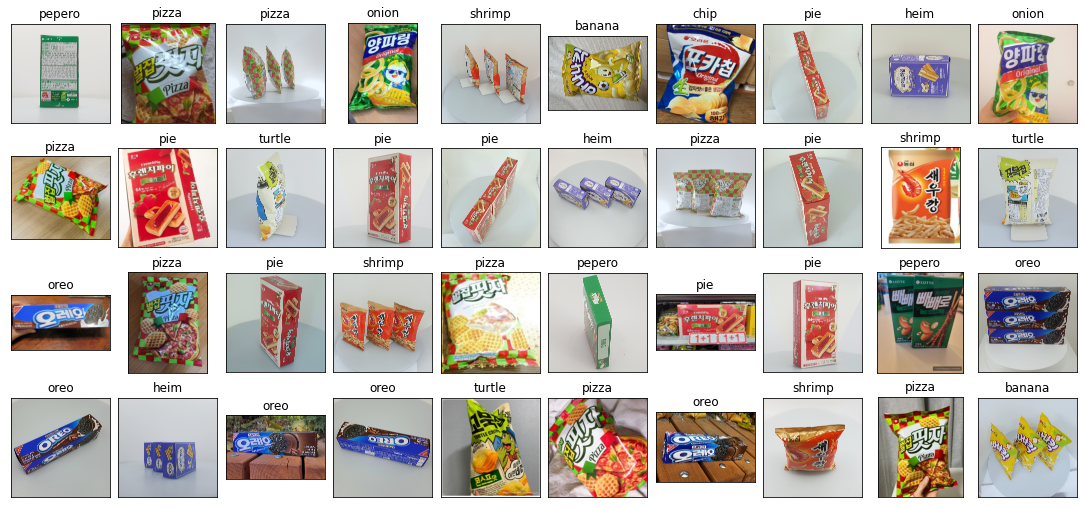

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

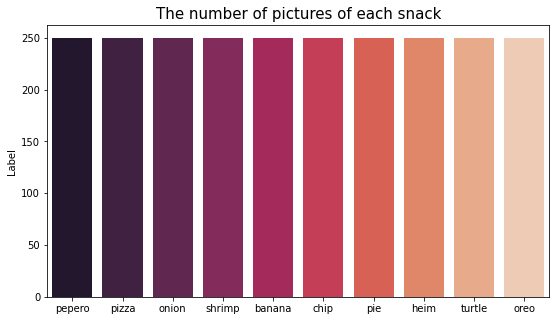

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("The number of pictures of each snack", fontsize = 15)
plt.show()

### Image generator

 train data , test data 분리

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((2250, 2), (250, 2))

validation data 분리

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=0)
train_df.shape, valid_df.shape

((2025, 2), (225, 2))

In [ ]:
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col='Filepath',
                                              y_col='Label',
                                              target_size = (75, 75),
                                              batch_size = 10,
                                              class_mode = 'categorical')
val_gen  = train_datagen.flow_from_dataframe(valid_df,
                                              x_col='Filepath',
                                              y_col='Label',
                                              target_size = (75, 75),
                                              batch_size = 10,
                                              class_mode = 'categorical')



Found 2025 validated image filenames belonging to 10 classes.
Found 225 validated image filenames belonging to 10 classes.


In [ ]:
for data_batch, labels_batch in train_gen:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (10, 75, 75, 3)
배치 레이블 크기: (10, 10)


In [ ]:
labels_batch

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75, 75, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

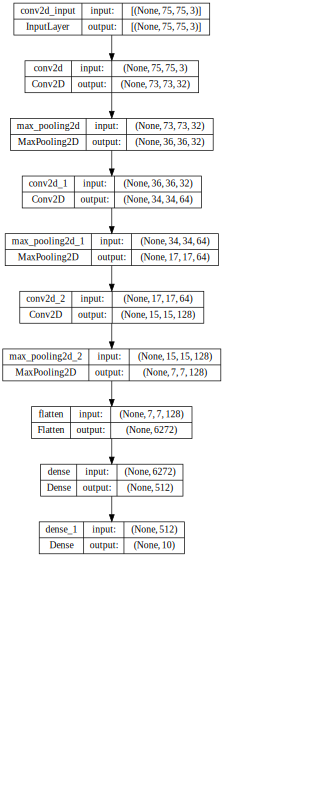

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

dot_res = model_to_dot(model,show_shapes=True, dpi=50).create(prog='dot', format='svg')
fi = open("model_cnn_1.svg", 'wb')
fi.write(dot_res)
fi.close()

SVG(dot_res)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

### Model Compile

모델 학습방법 설정

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
%%time

Hist_dandc = model.fit(train_gen,
                       steps_per_epoch = 50,
                       epochs = 100,
                       validation_data = val_gen,
                       validation_steps = 5)

Epoch 1/100
50/50 [==============================] - 186s 4s/step - loss: 1.9702 - accuracy: 0.3060 - val_loss: 1.2671 - val_accuracy: 0.5600
Epoch 2/100
50/50 [==============================] - 138s 3s/step - loss: 1.2084 - accuracy: 0.5495 - val_loss: 1.1940 - val_accuracy: 0.5400
Epoch 3/100
50/50 [==============================] - 108s 2s/step - loss: 0.7324 - accuracy: 0.7480 - val_loss: 0.8910 - val_accuracy: 0.7200
Epoch 4/100
50/50 [==============================] - 93s 2s/step - loss: 0.4253 - accuracy: 0.8700 - val_loss: 0.6555 - val_accuracy: 0.8600
Epoch 5/100
50/50 [==============================] - 93s 2s/step - loss: 0.5027 - accuracy: 0.8480 - val_loss: 0.6577 - val_accuracy: 0.7600
Epoch 6/100
50/50 [==============================] - 78s 2s/step - loss: 0.3494 - accuracy: 0.8660 - val_loss: 0.4825 - val_accuracy: 0.8400
Epoch 7/100
50/50 [==============================] - 67s 1s/step - loss: 0.4534 - accuracy: 0.8440 - val_loss: 0.2241 - val_accuracy: 0.9400
Epoch 8/10

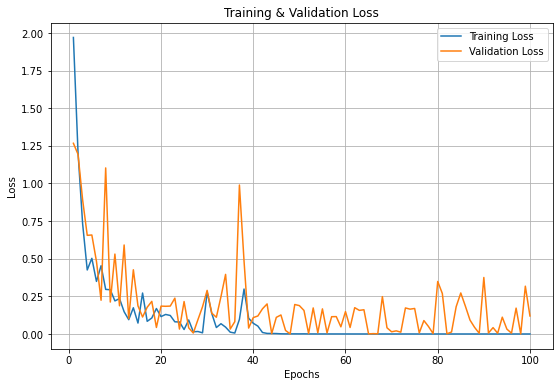

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

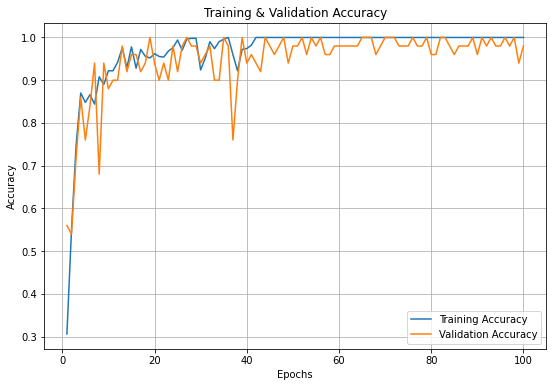

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
                 test_df,
                 x_col='Filepath',
                 y_col='Label',
                 target_size = (75, 75),
                 batch_size = 10,
                 class_mode = 'categorical')

Found 250 validated image filenames belonging to 10 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 5)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

5/5 [==============================] - 13s 3s/step - loss: 0.1720 - accuracy: 0.9800
Loss = 0.17198
Accuracy = 0.98000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/2nd_cnn(nr).h5')

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 119934
-rw------- 1 root root    35432 Oct  7 06:34  001_Model_iris.h5
-rw------- 1 root root 41499528 Oct 12 04:58  002_dogs_and_cats_small.h5
-rw------- 1 root root 39777040 Nov 23 06:27 '2nd_cnn(nr).h5'
-rw------- 1 root root 41499528 Nov 16 04:34  snacks01.h5


모델 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model
model_1 = load_model('/content/drive/My Drive/Colab Notebooks/models/snack_cnn_1.h5')